# Income of the Aged
### Replicating charts using the CPS ASEC

The Social Security Administration used to publish a report called the [Income of the Aged Chartbook](https://www.ssa.gov/policy/docs/chartbooks/income_aged/index.html) but no longer seem to do so. The report made some simple but powerful points about how older people survive despite a dwindling private pension system. The report also contained [instructions](https://www.ssa.gov/policy/docs/statcomps/income_pop55/2014/glossary.html) that make it easy to replicate report findings using [data](https://www.census.gov/data/datasets/time-series/demo/cps/cps-asec.2020.html) from the Annual Social and Economic Supplement to the Current Population Survey. 

Survey design changes affect the way an aged unit is calculated and the way income categories are defined. For example, the 2020 CPS includes same sex married couples, while the 2015 CPS did not. Additionally, the CPS removed the retirement income variables `RET_VAL1` and `RET_VAL2` and replaced them with pension and distribution variables `PEN_VAL1`, `PEN_VAL2`, `DST_VAL1`, and `DST_VAL2`. Because of these and other changes, the results are not strictly comparable between 2014 and 2020.

In [1]:
# import libraries
import os, re, struct
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import matplotlib as mpl

mpl.rcParams['axes.spines.right'] = False
mpl.rcParams['axes.spines.top'] = False

os.chdir('/home/brian/Documents/ASEC/data/')

### Example 1.
Replicate chart from page 17 of the 2014 chartbook:

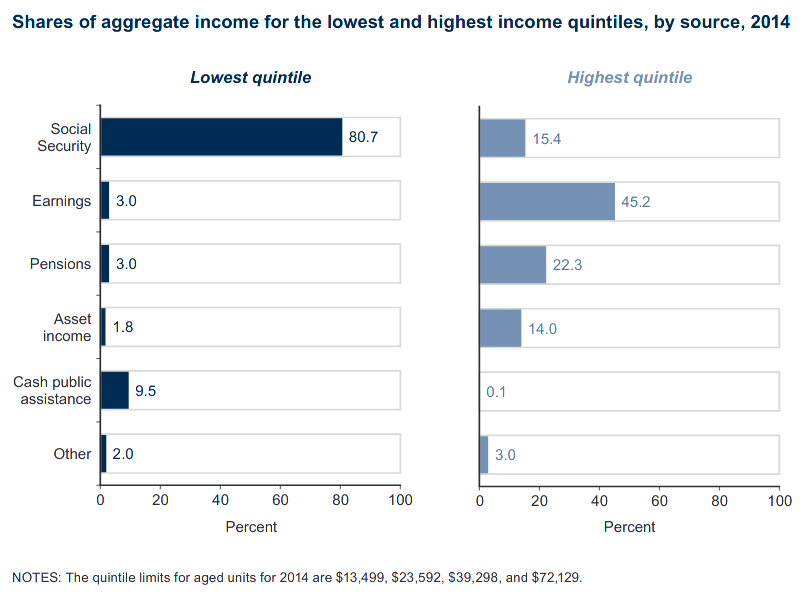

In [2]:
# Define categories of income
def asset_income(row):
    tot = row.INT_VAL + row.DIV_VAL + row.RNT_VAL
    if row.OI_OFF in [5, 6, 7, 8]:
        tot += row.OI_VAL
    if row.SUR_SC1 == 8:
        tot += row.SUR_VAL1
    if row.SUR_SC2 == 8:
        tot += row.SUR_VAL2
    return tot


def pension_income(row):
    tot = row.PNSN_VAL + row.ANN_VAL
    if row.OI_OFF in [2, 13]:
        tot += row.OI_VAL
    if row.SUR_SC1 in [1, 2, 3, 4, 5, 9]:
        tot += row.SUR_VAL1
    if row.SUR_SC2 in [1, 2, 3, 4, 5, 9]:
        tot += row.SUR_VAL2
    if row.DIS_SC1 in range(2, 7):
        tot += row.DIS_VAL1
    if row.DIS_SC2 in range(2, 7):
        tot += row.DIS_VAL2
    if row.DST_SC1 in range(1, 7):
        tot += row.DST_VAL1
    if row.DST_SC2 in range(1, 7):
        tot += row.DST_VAL2
    return tot

        
def cpa_income(row):
    tot = row.SSI_VAL + row.PAW_VAL
    if row.OI_OFF in [3, 4]:
        tot += row.OI_VAL
    return tot

In [3]:
# Retrieve data
var = ['PH_SEQ', 'A_LINENO', 'A_AGE', 'A_SEX', 'A_MARITL', 
       'A_SPOUSE', 'PRDTRACE', 'PRDTHSP', 'PTOTVAL', 'PEARNVAL', 
       'SS_VAL', 'OI_OFF', 'OI_VAL', 'DIV_VAL', 'INT_VAL', 
       'ANN_VAL', 'PNSN_VAL', 'PAW_VAL', 'SSI_VAL', 'RNT_VAL', 
       'SUR_SC1', 'SUR_SC2', 'SUR_VAL1', 'SUR_VAL2',
       'DIS_SC1', 'DIS_SC2', 'DIS_VAL1', 'DIS_VAL2', 
       'DST_SC1', 'DST_SC2', 'DST_VAL1', 'DST_VAL2']
df = (pd.read_csv('pppub20.csv', usecols=var)
        .query('A_AGE >= 65 or A_MARITL in [1, 2]'))

# Create custome income subcategories
df['ASSET'] = df.apply(asset_income, axis=1)
df['PENSION'] = df.apply(pension_income, axis=1)
df['CPA'] = df.apply(cpa_income, axis=1)
df['OTHER'] = (df.PTOTVAL - df.PEARNVAL - df.SS_VAL 
               - df.ASSET - df.PENSION - df.CPA)

In [4]:
# Convert from person level to Aged Units (au)
# Unmarried aged units
group = lambda x: np.where(x.A_SEX == 1, 'Unmarried man', 'Unmarried woman')
keep_columns = ['A_AGE', 'PRDTRACE', 'PRDTHSP', 'GROUP',
                'SS_VAL', 'PTOTVAL', 'PEARNVAL', 'PENSION', 
                'CPA', 'ASSET', 'OTHER']
au = (df.query('A_MARITL not in [1, 2]')
      .assign(GROUP = group)
      .loc[:, keep_columns])

# Married aged units
mc = df.query('A_MARITL in [1, 2]')
match_columns = ['PH_SEQ', 'A_LINENO', 'A_AGE', 'A_SEX', 'SS_VAL', 
                 'PTOTVAL', 'PEARNVAL', 'PENSION', 'CPA', 'ASSET', 
                 'OTHER']
# Create new dataframe of spouses and merge to combine
rename = {'A_LINENO': 'A_SPOUSE'}
for var in match_columns[2:]:
    rename[var] = f'SPOUSE_{var}'
spouses = mc[match_columns].rename(rename, axis=1) 
m = mc.merge(spouses).query('A_AGE > 64 or SPOUSE_A_AGE > 64')
m['GROUP'] = 'Married couple'

# Combine person income with spouse income across each category 
income_categories = ['PTOTVAL', 'PEARNVAL', 'SS_VAL', 
                     'PENSION', 'ASSET', 'CPA', 'OTHER']
for cat in income_categories:
    m[cat] = m[cat] + m[f'SPOUSE_{cat}']

# Identify which person from couple donates characteristics to AU    
main = (((m.A_SEX == 1) & (m.A_SEX != m.SPOUSE_A_SEX)) | 
        (((m.A_SEX == m.SPOUSE_A_SEX) & (m.A_AGE > m.SPOUSE_A_AGE)) |
         ((m.A_SEX == m.SPOUSE_A_SEX) & (m.A_AGE == m.SPOUSE_A_AGE) & 
          (m.A_LINENO < m.A_SPOUSE))))

# Combine unmarried aged units with married aged units
au = au.append(m.loc[main, keep_columns])    

In [5]:
# Functions to calculate quintiles and share of quintile income
def quintile_values(group):
    quintiles = [('Lowest quintile', 0.2), ('Second quintile', 0.4), 
                 ('Third quintile', 0.6), ('Highest quintile', 0.8)]
    qvals = {name: group.PTOTVAL.quantile(q=q)
             for name, q in quintiles}
    return qvals

def category_share(group, quintile_values):
    results = {}
    inc_cats = [('Social\nSecurity', 'SS_VAL'), ('Earnings', 'PEARNVAL'), 
            ('Pensions', 'PENSION'), ('Asset\nincome', 'ASSET'), 
            ('Cash public\nassistance', 'CPA'), ('Other', 'OTHER')]
    for qname, qval in quintile_values.items():
        df = (group[group.PTOTVAL > qval] if qname == 'Highest quintile' 
              else group[group.PTOTVAL < qval])
        results[qname] = {}
        for name, inc_cat in inc_cats:
            share = (df[inc_cat].sum() / 
                     df['PTOTVAL'].sum()) * 100
            results[qname][name] = share
    return results

In [6]:
# Identify group for creating chart
qvals = quintile_values(au)
data = category_share(au, qvals)
df = pd.DataFrame(data).iloc[::-1][['Lowest quintile', 'Highest quintile']]

In [7]:
# Create chart with share of quintile income in each category
def chart_income_share(df, name):
    colors = ['#203354', '#74A0C2']
    title = ('Shares of aggregate income for the lowest and highest income '+
             'quintiles, by source, 2019')
    fig = df.plot(kind='barh', subplots=True, layout=(1,2), sharey=True, 
                  legend=None, xlim=(-0.2,101), color=colors,
                  width=0.65, figsize=(11, 6), zorder=1)
    
    for quintile, axis, color in [('Lowest quintile', 0, colors[0]), 
                                  ('Highest quintile', 1, colors[1])]:
        (pd.Series([100, 100, 100, 100, 100, 100])
           .plot(kind='barh', width=0.65, ax=fig[0, axis], fill=None, 
                 ec='lightgray', zorder=0))
        fig[0, axis].set_title(quintile, color=color, size=16, 
                               style='italic', weight='heavy')
        fig[0, axis].text(40, -1.2, 'Percent', fontsize=12)
        fig[0, axis].tick_params(axis='x', labelsize=12)
        for y, x in enumerate(df[quintile]):
            fig[0, axis].text(x + 1.5, y - 0.08, f'{x:.1f}', size=14, color=color)
    fig[0, 0].set_yticklabels(df.index)
    fig[0, 0].tick_params(axis='y', labelsize=14)
    plt.gcf().text(0, 1.05, name, fontsize=14, weight='bold')
    plt.gcf().text(0, 0.98, title, fontsize=16)
    fn = ('NOTES: The quintile limits for aged units for 2019 are '+
          f'\${qvals["Lowest quintile"]:,.0f}, \${qvals["Second quintile"]:,.0f}, '+
          f'\${qvals["Third quintile"]:,.0f}, and \${qvals["Highest quintile"]:,.0f}.')
    plt.gcf().text(0, -0.03, fn, fontsize=13)
    plt.show()

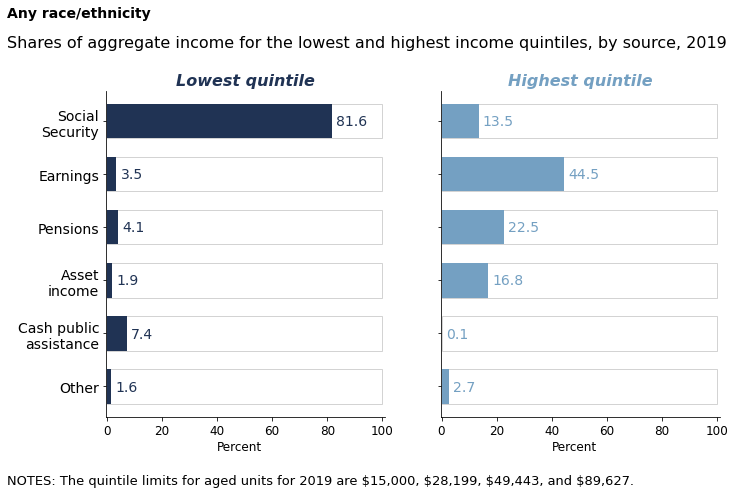

In [8]:
chart_income_share(df, name='Any race/ethnicity')

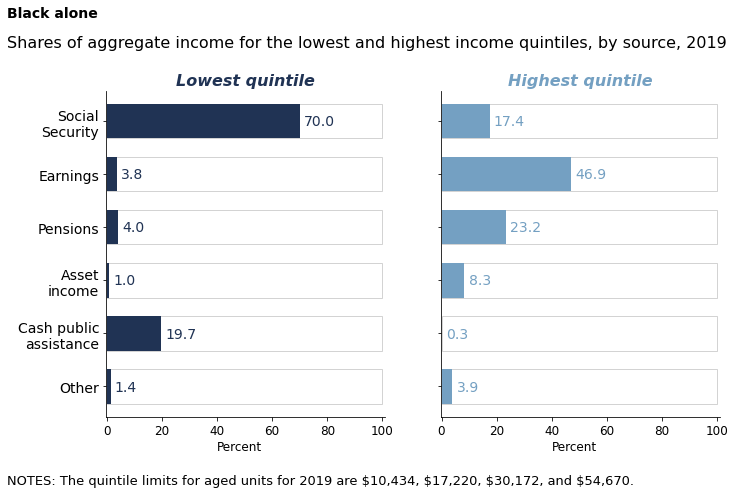

In [9]:
# Same chart for Black alone, non-Hispanic
group = au.query('PRDTRACE == 2')
qvals = quintile_values(group)
data = category_share(group, qvals)
df = pd.DataFrame(data).iloc[::-1][['Lowest quintile', 'Highest quintile']]
chart_income_share(df, 'Black alone')

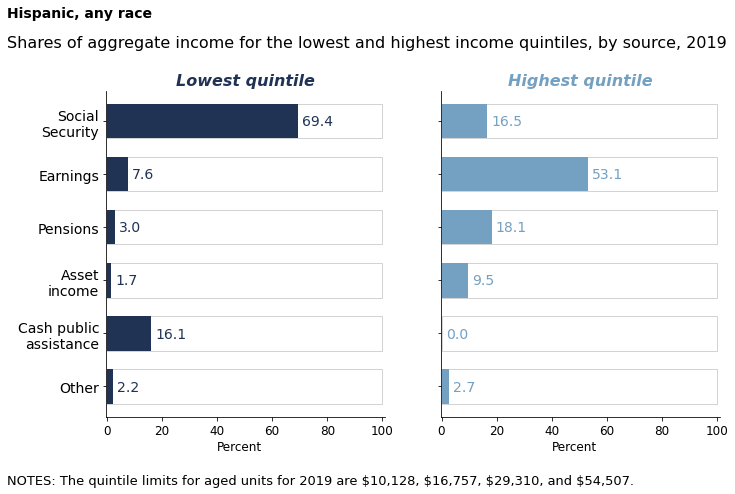

In [10]:
# Same chart for Hispanic, any race
group = au.query('PRDTHSP > 0')
qvals = quintile_values(group)
data = category_share(group, qvals)
df = pd.DataFrame(data).iloc[::-1][['Lowest quintile', 'Highest quintile']]
chart_income_share(df, 'Hispanic, any race')

### Example 2.
Replicate chart from page 28 of the 2014 chartbook:
    
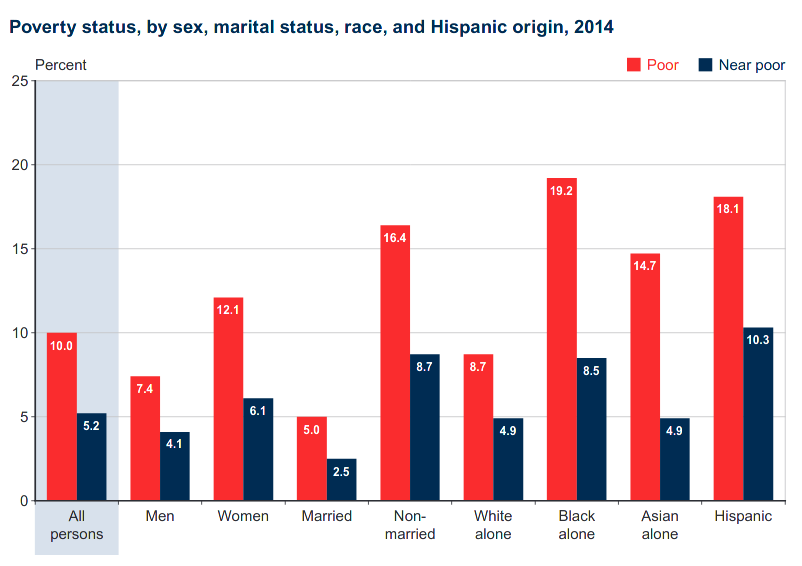

In [11]:
# Replicate chart from example 2
def chart_poverty_group(df, ymax=25):
    colors = ['#F21F1F','#203354']      
    final.plot(kind='bar', ylim=(0, ymax), color=colors,
               width=0.75, figsize=(13, 7), rot=0, zorder=2)
    plt.xlim(-0.5, 8.5)
    plt.axvline(8.5, color='lightgray')
    plt.grid(axis='y', zorder=0)
    plt.tick_params(axis='both', labelsize=14)
    # Box around all persons
    plt.axvspan(-0.5, 0.5, ymin=-0.13, fill=True, linewidth=0, 
                color='#74A0C2', alpha=0.25, zorder=1, clip_on=False)
    # Value labels
    for series, offset in [(0, -0.19), (1, 0.19)]:
        for i, val in enumerate(final.iloc[:,series]):
            plt.text(i + offset, val - ymax/25, f'{val:.1f}', color='white', 
                     ha='center', weight='bold')
    # Title and other labels        
    title = ('Poverty status, by sex, marital status, race, and '+
             'Hispanic origin, 2019')  
    plt.gcf().text(0.1, 0.96, title, fontsize=15, weight='bold')
    plt.gcf().text(0.125, 0.9, 'Percent', fontsize=13)
    legend_x = (1 - (np.sqrt((len(final.iloc[:,0].name) + 
                    len(final.iloc[:,1].name))) / 10.5))
    plt.legend(ncol=2, loc=(legend_x, 1.0), frameon=False, 
               labelcolor='linecolor', fontsize=14)
    plt.show()

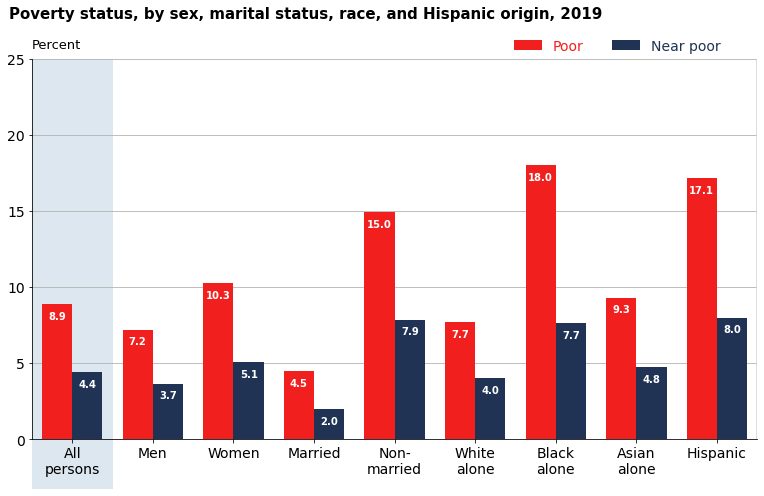

In [12]:
# Collect data and define groups
var = ['A_AGE', 'A_SEX', 'A_MARITL', 'PRDTRACE', 'PRDTHSP', 
       'PERLIS', 'MARSUPWT']
df = (pd.read_csv('pppub20.csv', usecols=var)
        .query('A_AGE >= 65'))

# Calculate poverty and near poverty
cats = [('All\npersons', 'A_AGE >= 65'), ('Men', 'A_SEX == 1'), 
        ('Women', 'A_SEX == 2'), ('Married', 'A_MARITL in [1, 2]'),
        ('Non-\nmarried', 'A_MARITL not in [1, 2]'), 
        ('White\nalone', 'PRDTRACE == 1'),
        ('Black\nalone', 'PRDTRACE == 2'),
        ('Asian\nalone', 'PRDTRACE == 4'),
        ('Hispanic', 'PRDTHSP > 0')]
final = pd.DataFrame()
for name, query in cats:
    data = df.query(query)
    res = (data.groupby('PERLIS').MARSUPWT.sum() / 
           data.MARSUPWT.sum()) * 100
    final.at[name, 'Poor'] = res[1]
    final.at[name, 'Near poor'] = res[2]
    
# Create chart
chart_poverty_group(final)

The results in the chart above can be verified in part using figures from the [Income and Poverty in the United States: 2019](https://www.census.gov/library/publications/2020/demo/p60-270.html), see, for example, table B-6.

### New Chart

Create a new chart that uses the same groups as above but instead shows the poverty rate based on the Supplemental Poverty Measure (SPM) and the poverty rate without Social Security.

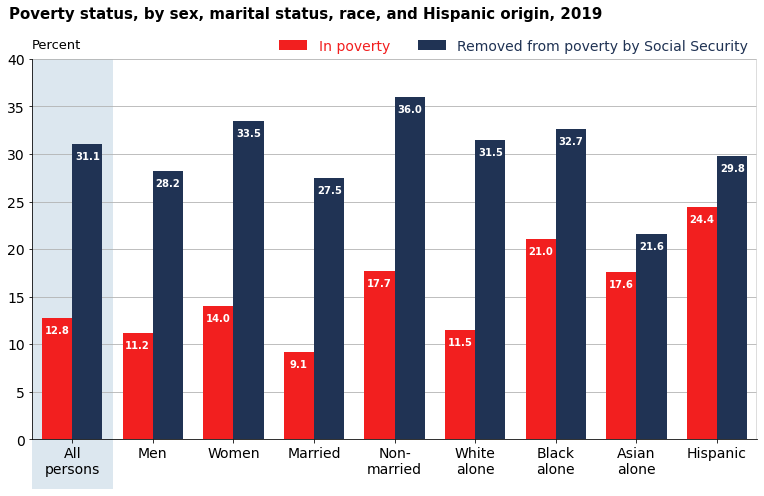

In [13]:
# Collect data and define groups
var = ['A_AGE', 'A_SEX', 'A_MARITL', 'PRDTRACE', 'PRDTHSP', 
       'SPM_RESOURCES', 'SPM_ID', 'SPM_WEIGHT', 
       'SPM_POVTHRESHOLD', 'SS_VAL', 'SPM_TOTVAL']
df = (pd.read_csv('pppub20.csv', usecols=var)
        .query('A_AGE >= 65'))
df['SPM_SS_VAL'] = df.groupby('SPM_ID').SS_VAL.transform('sum')
df['SPM'] = np.where(df['SPM_RESOURCES'] < df['SPM_POVTHRESHOLD'], 1, 0)
df['NO_SS'] = df['SPM_RESOURCES'] - df['SPM_SS_VAL']
df['SPM_NO_SS'] = np.where((df['NO_SS'] < df['SPM_POVTHRESHOLD']) & 
                           (df['SPM'] == 0), 1, 0)

# Calculate poverty and near poverty
final = pd.DataFrame()
for name, query in cats:
    data = df.query(query)
    spm = (data.groupby('SPM').SPM_WEIGHT.sum() / 
            data.SPM_WEIGHT.sum()) * 100
    spm_ss = (data.groupby('SPM_NO_SS').SPM_WEIGHT.sum() / 
              data.SPM_WEIGHT.sum()) * 100
    final.at[name, 'In poverty'] = spm[1]
    final.at[name, 'Removed from poverty by Social Security'] = spm_ss[1]
    
# Create chart
chart_poverty_group(final, ymax=40)

Some results from the above chart can be verified using the [Supplemental Poverty Measure: 2019](https://www.census.gov/library/publications/2020/demo/p60-272.html), see, for example, Table 6.